In [1]:
suppressWarnings(suppressPackageStartupMessages({
    library(tidyverse)
    library(data.table)
}))


In [2]:
res_d <- '/scratch/groups/mrivas/projects/PRS/private_output/202009_batch'


In [6]:
eval_1_df <- fread(file.path(res_d, 'snpnet.eval.1_fit_w_val.tsv')) %>% rename('GBE_ID'='#GBE_ID')
eval_2_df <- fread(file.path(res_d, 'snpnet.eval.2_refit.tsv')) %>% rename('GBE_ID'='#GBE_ID')

In [37]:
bind_rows(
    eval_1_df %>% mutate(run_idx = '1_fit_w_val'),
    eval_2_df %>% mutate(run_idx = '2_refit')
) %>%
filter(split == 'test', n_variables>0) %>%
rename('metric'='geno_covar') %>%
select(GBE_ID, family, run_idx, metric) %>%
unique() %>% spread(run_idx, metric) -> df

In [49]:
plots <- list()
for(f in c('binomial', 'gaussian')) {
    df %>% drop_na(`1_fit_w_val`, `2_refit`) %>%
    filter(family == f) %>%
    ggplot(aes(x = `1_fit_w_val`, y = `2_refit`)) + 
    geom_abline(slope=1, intercept=0, color='red') + 
    geom_point(alpha=.3) + theme_bw()+
    labs(
        title=ifelse(
            f == 'binomial', 
            'Binary phenotypes (family: Binomial)', 
            'Quantitative phenotypes (family: Gaussian)'
        ),
        x = 'Model performance trainined on training (70%) and validation (10%) sets',
        y = 'Model performance trainined on the combined (70% + 10%) set'
    ) +
    geom_vline(xintercept = ifelse(f == 'binomial', 0.5, 0), color='gray') + 
    geom_hline(yintercept = ifelse(f == 'binomial', 0.5, 0), color='gray') -> plots[[f]]
}


In [62]:
ggsave('8_plot_eval.png', gridExtra::arrangeGrob(plots[['binomial']], plots[['gaussian']], ncol=2), width=12, height=6)

In [60]:

summary(lm(`2_refit` ~ 0 + `1_fit_w_val`, df %>% drop_na(`1_fit_w_val`, `2_refit`) %>% filter(family == 'binomial')))$coefficients

,Estimate,Std. Error,t value,Pr(>|t|)
`1_fit_w_val`,1.001834,0.0004566792,2193.736,0


In [59]:

summary(lm(`2_refit` ~ 0 + `1_fit_w_val`, df %>% drop_na(`1_fit_w_val`, `2_refit`) %>% filter(family == 'gaussian')))$coefficients

,Estimate,Std. Error,t value,Pr(>|t|)
`1_fit_w_val`,1.006169,0.0004981424,2019.842,0


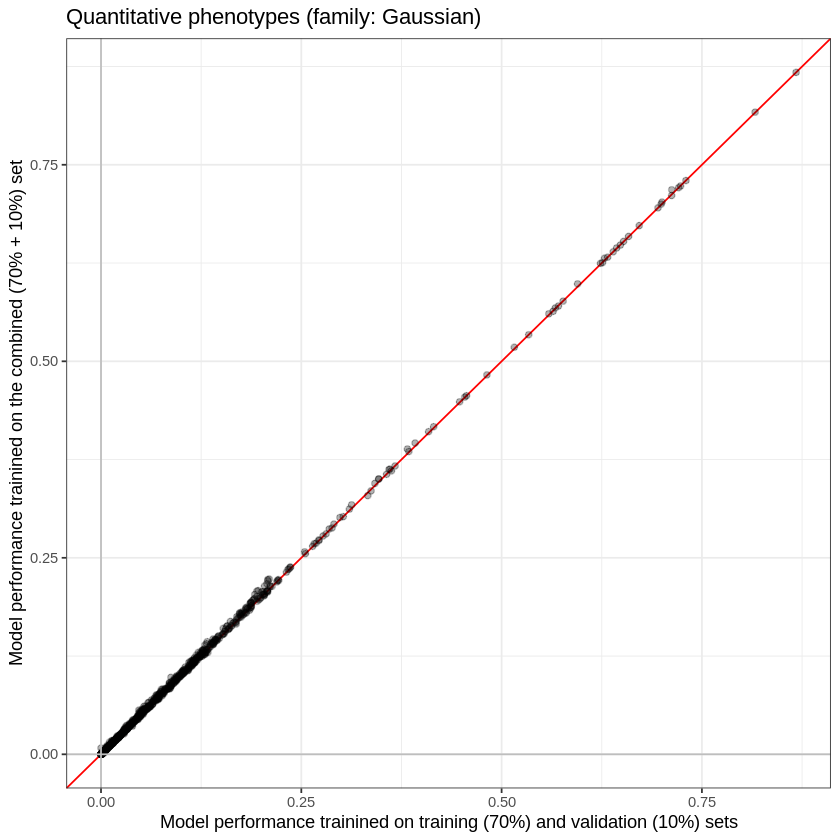

In [51]:
plots[['gaussian']]

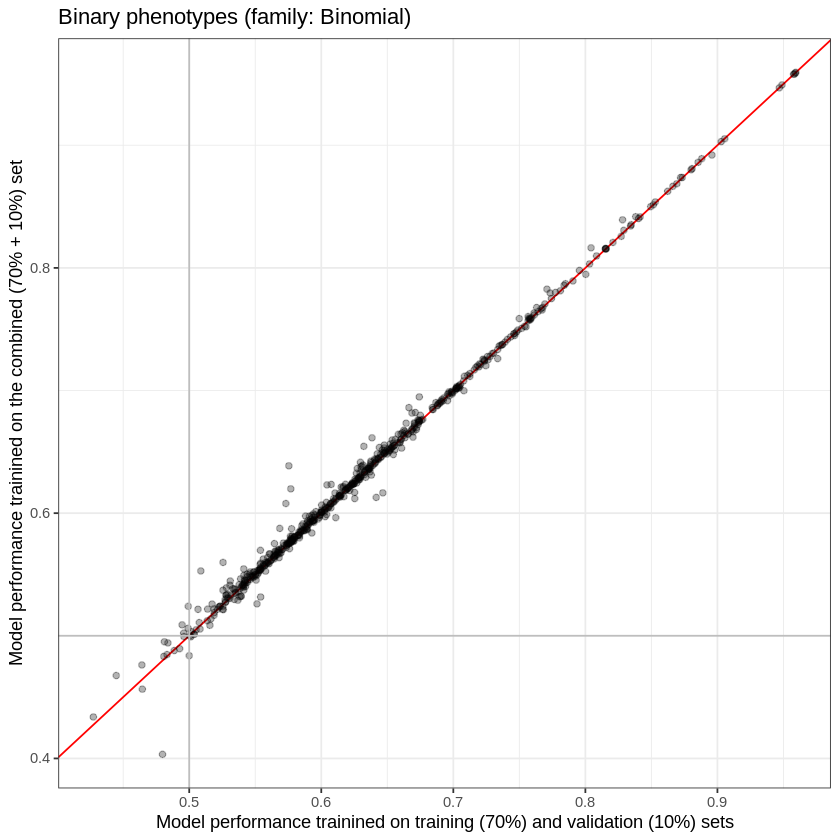

In [50]:
plots[['binomial']]

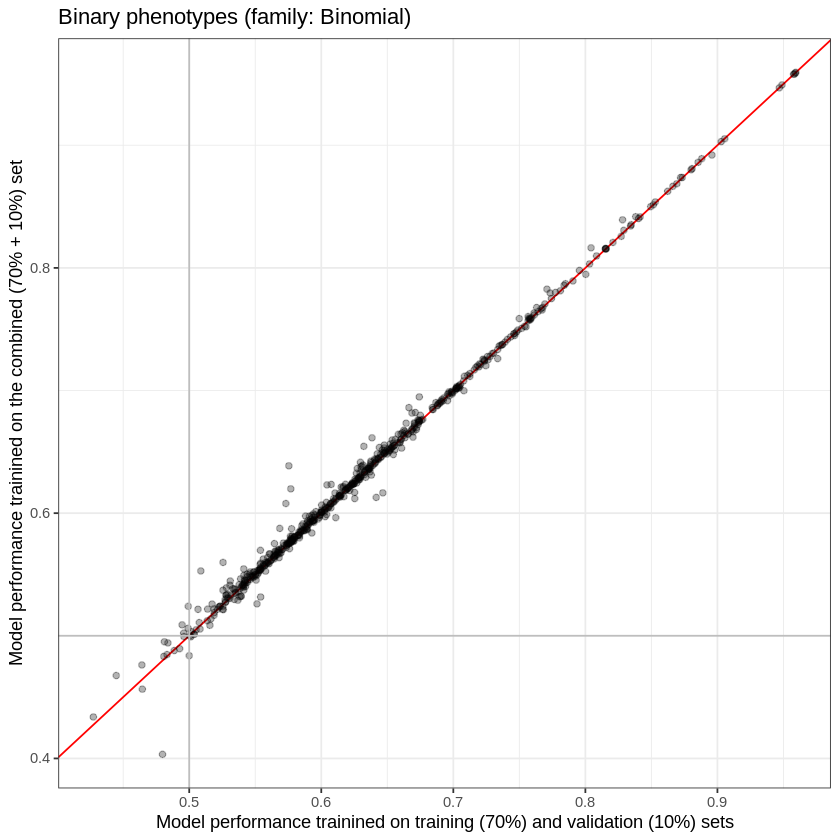

In [48]:
df %>% drop_na(`1_fit_w_val`, `2_refit`) %>%
filter(family == 'binomial') %>%
ggplot(aes(x = `1_fit_w_val`, y = `2_refit`)) + 
geom_abline(slope=1, intercept=0, color='red') + 
geom_point(alpha=.3) + theme_bw()+
labs(
    x = 'Model performance trainined on training (70%) and validation (10%) sets',
    y = 'Model performance trainined on the combined (70% + 10%) set'
) +
geom_vline(xintercept = 0.5, color='gray') + 
geom_hline(yintercept = 0.5, color='gray') +
labs(
    title='Binary phenotypes (family: Binomial)'
)



In [17]:
tmp_df %>% filter(GBE_ID == 'INI23201') %>% head()

GBE_ID,family,run_idx,metric
<chr>,<chr>,<dbl>,<dbl>
INI23201,gaussian,1,0.2720486
INI23201,gaussian,2,0.2729124


In [18]:
tmp_df %>% filter(GBE_ID == 'INI23201') %>% 
spread(run_idx, metric)

GBE_ID,family,1,2
<chr>,<chr>,<dbl>,<dbl>
INI23201,gaussian,0.2720486,0.2729124


In [ ]:
spread(run_idx, metric, -GBE_ID, -family)